In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints, transforms
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc.util import summary
import os
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (7, 4)

# Chapter 4 - Extending Linear Models

In [4]:
babies = pd.read_csv(os.path.abspath('.') + '/data/babies.csv')
babies

,Month,Length
0,0,48.5
1,0,50.5
2,0,50.5
3,0,52.0
4,0,47.5
...,...,...
795,24,87.5
796,24,82.5
797,24,88.5
798,24,89.0


## 4.1 Transforming Covariates

### Figure 4.2

In [5]:
X_ = torch.from_numpy(babies['Month'].values.reshape(-1, 1)).to(torch.float)
#X_ = torch.tensor(X_).float()

y = torch.from_numpy(babies['Length'].values).to(torch.float)
#y = torch.tensor(y).float()

In [6]:
def linear_babies(month, length=None):

    N, P = month.shape
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0, 10.).expand([P]))
    sigma = pyro.sample('sigma', dist.HalfNormal(10.))
    mu = beta_0 + torch.matmul(beta_1, month.T)
    
    with pyro.plate('plate', size=N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=length)

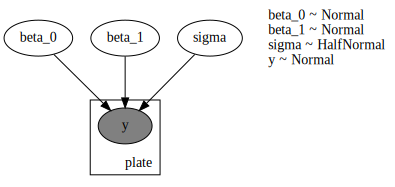

In [7]:
pyro.render_model(
    linear_babies, 
    model_args=(X_, y),
    render_distributions=True
    )

In [8]:
kernel = NUTS(linear_babies, adapt_step_size=True)
mcmc_linear_babies = MCMC(kernel, 500, 300)
mcmc_linear_babies.run(X_, y)

Sample: 100%|██████████| 800/800 [00:05, 144.48it/s, step size=3.89e-01, acc. prob=0.917]


In [9]:
mcmc_babie_samples = mcmc_linear_babies.get_samples(1000)
predictive = Predictive(linear_babies, mcmc_babie_samples)(X_, None)

az_linear_babies = az.from_pyro(
    posterior=mcmc_linear_babies, posterior_predictive=predictive)

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


In [10]:
y_mu = predictive['y'].mean(axis=0)

/Users/gabestechschulte/miniforge3/envs/probs/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


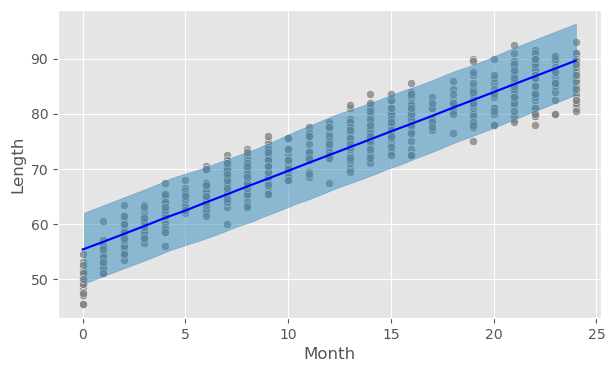

In [13]:
sns.scatterplot(x=babies['Month'], y=babies['Length'], color='grey', alpha=0.75)
sns.lineplot(x=babies['Month'], y=y_mu, color='blue')
az.plot_hdi(x=babies['Month'], y=predictive['y'].numpy());

### Figure 4.3

In [14]:
def sqrt_babies(month, length=None):

    N, P = month.shape
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0, 10.).expand([P]))
    sigma = pyro.sample('sigma', dist.HalfNormal(10.))
    mu = beta_0 + torch.matmul(beta_1, torch.sqrt(month.T))
    
    with pyro.plate('plate', size=N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=length)

In [15]:
kernel = NUTS(sqrt_babies, adapt_step_size=True)
mcmc_sqrt = MCMC(kernel, 500, 300)
mcmc_sqrt.run(X_, y)

Sample: 100%|██████████| 800/800 [00:06, 119.31it/s, step size=2.91e-01, acc. prob=0.943]


In [16]:
mcmc_sqrt_babie_samples = mcmc_sqrt.get_samples(1000)
predictive_sqrt = Predictive(sqrt_babies, mcmc_sqrt_babie_samples)(X_, None)

az_sqrt_babies = az.from_pyro(
    posterior=mcmc_sqrt, posterior_predictive=predictive_sqrt)

posterior predictive shape not compatible with number of chains and draws.This can mean that some draws or even whole chains are not represented.


In [17]:
y_mu = predictive_sqrt['y'].mean(axis=0)

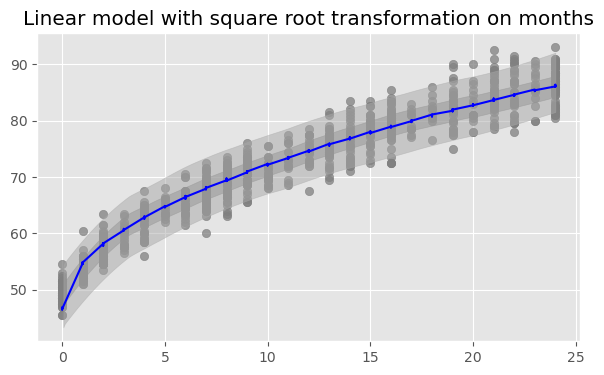

In [21]:
plt.scatter(babies['Month'], babies['Length'], color='grey', alpha=0.75)
plt.plot(babies['Month'], y_mu, color='blue')
az.plot_hdi(x=babies['Month'], y=az_sqrt_babies['posterior_predictive']['y'], hdi_prob=.50, color='grey')
az.plot_hdi(x=babies['Month'], y=az_sqrt_babies['posterior_predictive']['y'], hdi_prob=.94, color='darkgrey')
plt.title('Linear model with square root transformation on months');

## 4.2 - Varying Uncertainty

In [35]:
def varying_uncertainty(month, length=None):

    N, P = month.shape
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0, 10.).expand([P]))
    delta = pyro.sample('delta', dist.HalfNormal(10.).expand([2]))
    sigma = pyro.deterministic(
        'sigma', 
        delta[0].unsqueeze(-1) + torch.matmul(delta[1].unsqueeze(-1), month.T)
        )
    mu = beta_0 + torch.matmul(beta_1, torch.sqrt(month.T))
    
    with pyro.plate('plate', size=N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=length)

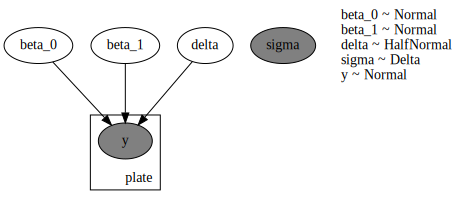

In [32]:
pyro.render_model(
    varying_uncertainty,
    (X_, y),
    render_distributions=True
)

In [36]:
varying_sigma_mcmc = MCMC(NUTS(varying_uncertainty), num_samples=500, warmup_steps=300)
varying_sigma_mcmc.run(X_, y)

Sample: 100%|██████████| 800/800 [00:08, 95.74it/s, step size=3.06e-01, acc. prob=0.912] 


In [37]:
varying_sigma_samples = varying_sigma_mcmc.get_samples(1000)
varying_sigma_post_pred = Predictive(
    varying_uncertainty, varying_sigma_samples)(X_, None)

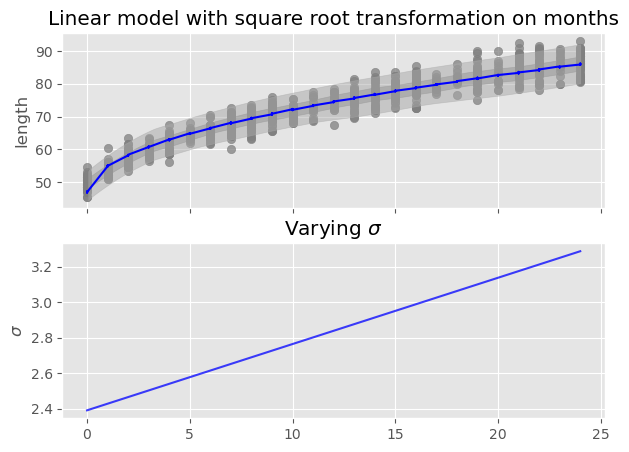

In [59]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7, 5))

ax[0].scatter(babies['Month'], babies['Length'], color='grey', alpha=0.75)
ax[0].plot(babies['Month'], varying_sigma_post_pred['y'].mean(axis=0), color='blue')
az.plot_hdi(x=babies['Month'], y=varying_sigma_post_pred['y'], hdi_prob=.50, color='grey', ax=ax[0])
az.plot_hdi(x=babies['Month'], y=varying_sigma_post_pred['y'], hdi_prob=.94, color='darkgrey', ax=ax[0])
ax[0].set_ylabel('length')
ax[0].set_title('Linear model with square root transformation on months')

ax[1].plot(babies['Month'], varying_sigma_post_pred['sigma'].mean(axis=0)[0], color='blue', alpha=0.75)
ax[1].set_ylabel('$\sigma$')
ax[1].set_title('Varying $\sigma$');

## 4.3 - Interaction Effects

In [61]:
tips_df = pd.read_csv(os.path.abspath('.') + '/data/tips.csv')
tips_df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [62]:
total_bill_centered = torch.tensor((tips_df["total_bill"] - tips_df["total_bill"].mean()).values, dtype=torch.float32)
tips = torch.tensor(tips_df["tip"].values, dtype=torch.float)
smoker = torch.tensor(pd.Categorical(tips_df["smoker"]).codes, dtype=torch.float)

In [63]:
def interaction_model(bill, smoker, tips=None):

    beta = pyro.sample('beta', dist.Normal(0., 1.).expand([4]))
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))
    mu = beta[0] + beta[1] * bill + beta[2] * smoker + beta[3] * smoker * bill

    with pyro.plate('plate', len(bill)):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=tips)

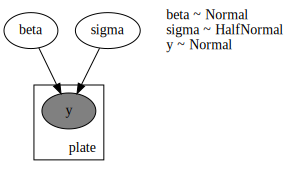

In [64]:
pyro.render_model(
    interaction_model,
    (total_bill_centered, smoker, tips), render_distributions=True)

In [65]:
interaction_mcmc = MCMC(NUTS(interaction_model), num_samples=500, warmup_steps=300)
interaction_mcmc.run(total_bill_centered, smoker, tips)

Sample: 100%|██████████| 800/800 [00:05, 144.46it/s, step size=4.95e-01, acc. prob=0.895]


In [ ]:
mcmc_interaction_samples = interaction_mcmc.get_samples(1000)
interaction_predictive = Predictive(interaction_model, mcmc_interaction_samples)
posterior_predictive = interaction_predictive(total_bill_centered, smoker, None)

az_inference_interaction = az.from_pyro(
    posterior=interaction_mcmc, posterior_predictive=posterior_predictive)

In [67]:
tip_mu = posterior_predictive['y'].mean(axis=0)
tip_std = posterior_predictive['y'].std(axis=0)

predictions = pd.DataFrame({
    'bill': total_bill_centered,
    'smoker': smoker,
    'tip': tips, 
    'tip_mu': tip_mu,
    'tip_std': tip_std,
    'tip_high': tip_mu + tip_std,
    'tip_low': tip_mu - tip_std
})

predictions = predictions.sort_values(by=['bill'])

In [68]:
smoker_df = predictions[predictions['smoker'] == 1]
nonsmoker_df = predictions[predictions['smoker'] == 0]

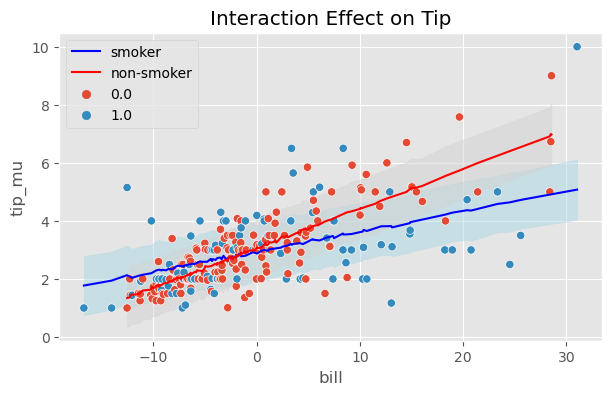

In [79]:
# colors are terrible - TO DO
sns.lineplot(
    x=smoker_df['bill'], y=smoker_df['tip_mu'], color='blue', label='smoker'
    )
plt.fill_between(
    smoker_df['bill'], smoker_df['tip_low'], smoker_df['tip_high'], 
    color='lightblue', alpha=0.5
    )
sns.lineplot(
    x=nonsmoker_df['bill'], y=nonsmoker_df['tip_mu'], color='red', label='non-smoker'
    )
plt.fill_between(
    nonsmoker_df['bill'], nonsmoker_df['tip_low'], nonsmoker_df['tip_high'],
    color='lightgrey', alpha=0.5
    )
sns.scatterplot(
    x=predictions['bill'], y=predictions['tip'], hue=predictions['smoker']
    )
plt.legend()
plt.title('Interaction Effect on Tip')
plt.show()

## 4.4 - Robust Regression

In [80]:
def generate_sales(*, days, mean, std, label):
    """code taken from the authors / book"""
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    
    return df

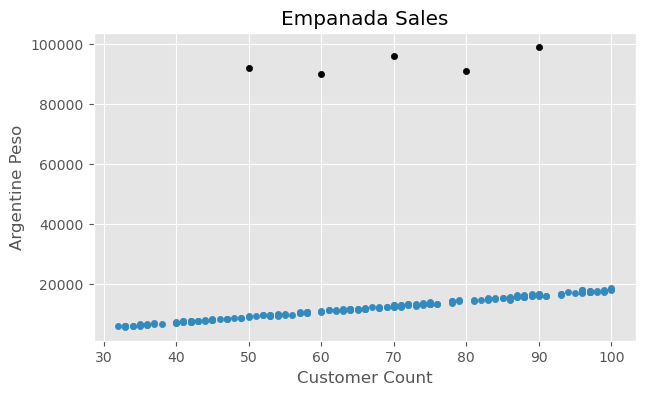

In [83]:
empanadas = generate_sales(days=200, mean=180, std=30, label="Empanada")

empanadas.iloc[0] = [50, 92000, "Empanada"]
empanadas.iloc[1] = [60, 90000, "Empanada"]
empanadas.iloc[2] = [70, 96000, "Empanada"]
empanadas.iloc[3] = [80, 91000, "Empanada"]
empanadas.iloc[4] = [90, 99000, "Empanada"]

empanadas = empanadas.sort_values("customers")

fig, ax = plt.subplots()
empanadas.sort_values("sales")[:-5].plot(x="customers", y="sales", kind="scatter", ax=ax);
empanadas.sort_values("sales")[-5:].plot(x="customers", y="sales", kind="scatter", c="black", ax=ax);

ax.set_ylabel("Argentine Peso")
ax.set_xlabel("Customer Count")
ax.set_title("Empanada Sales");

In [84]:
customer_count = torch.tensor(empanadas['customers'].values, dtype=torch.float)
sales = torch.tensor(empanadas['sales'].values, dtype=torch.float)

In [85]:
def robust_regression(customers, peso=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(50.))
    beta = pyro.sample('beta', dist.Normal(150., 20.))
    v = pyro.sample('dof', dist.HalfNormal(20.))

    mu = pyro.deterministic('mu', beta * customers)

    with pyro.plate('plate', len(customers)):
        sales = pyro.sample('sales', dist.StudentT(loc=mu, scale=sigma, df=v), obs=peso)

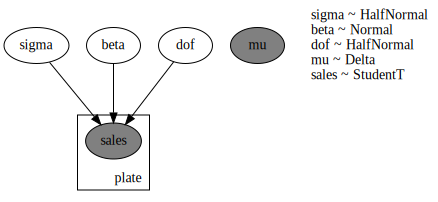

In [86]:
pyro.render_model(
    robust_regression, (customer_count, sales), render_distributions=True)

In [87]:
kernel = NUTS(robust_regression)
mcmc_robust = MCMC(kernel, 500, 300)
mcmc_robust.run(customer_count, sales)

Sample: 100%|██████████| 800/800 [00:09, 88.07it/s, step size=6.43e-01, acc. prob=0.925] 


In [88]:
mcmc_robust.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta    179.60      0.25    179.61    179.18    179.99    333.32      1.00
       dof      1.27      0.15      1.27      1.00      1.50    509.08      1.00
     sigma    150.67     12.30    150.52    128.41    168.89    479.97      1.00

Number of divergences: 0


In [ ]:
mcmc_robust_samples = mcmc_robust.get_samples(1000)
robust_predictive = Predictive(robust_regression, mcmc_robust_samples)(customer_count, None)
az_robust_inf = az.from_pyro(posterior=mcmc_robust, posterior_predictive=robust_predictive)

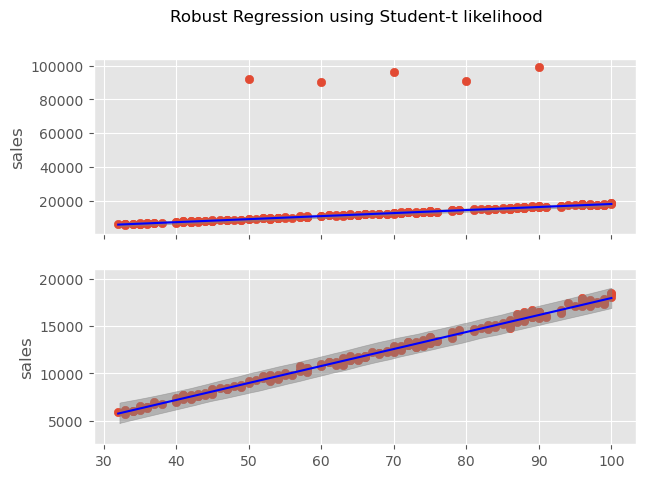

In [98]:
mu = az_robust_inf['posterior_predictive']['mu'].values.reshape(-1, len(customer_count)).mean(axis=0)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)

ax[0].scatter(customer_count, sales)
ax[0].plot(customer_count, mu, c='blue')
az.plot_hdi(
    customer_count, az_robust_inf['posterior_predictive']['sales'], 
    color='grey', ax=ax[0])
ax[0].set_ylabel('sales')


ax[1].scatter(customer_count, sales)
ax[1].plot(customer_count, mu, c='blue')
az.plot_hdi(
    customer_count, az_robust_inf['posterior_predictive']['sales'], 
    color='grey', ax=ax[1]
    )
ax[1].set_ylim(bottom=2500, top=21000)
ax[1].set_ylabel('sales')

plt.suptitle('Robust Regression using Student-t likelihood');

## 4.5 - Pooling, Multilevel Models, Mixed Effects

In [2]:
def generate_sales(*, days, mean, std, label):
    """code taken from authors / book"""
    np.random.seed(0)
    df = pd.DataFrame(index=range(1, days+1), columns=["customers", "sales"])
    for day in range(1, days+1):
        num_customers = stats.randint(30, 100).rvs()+1
        
        # This is correct as there is an independent draw for each customers orders
        dollar_sales = stats.norm(mean, std).rvs(num_customers).sum()
        
        df.loc[day, "customers"] = num_customers
        df.loc[day, "sales"] = dollar_sales
        
    # Fix the types as not to cause Theano errors
    df = df.astype({'customers': 'int32', 'sales': 'float32'})
    
    # Sorting will make plotting the posterior predictive easier later
    df["Food_Category"] = label
    df = df.sort_values("customers")
    
    return df

In [3]:
pizza_df = generate_sales(days=365, mean=13, std=5, label="Pizza")
sandwich_df = generate_sales(days=100, mean=6, std=5, label="Sandwich")
salad_days = 3
salad_df = generate_sales(days=salad_days, mean=8 ,std=3, label="Salad")

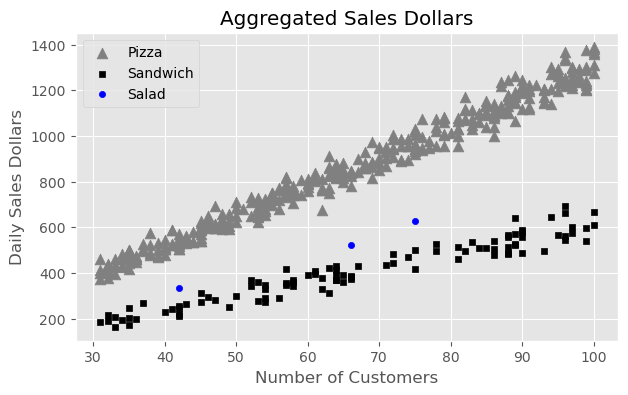

In [4]:
fig, ax = plt.subplots()
pizza_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c="grey", label="Pizza", marker="^", s=60);
sandwich_df.plot(x="customers", y="sales", kind="scatter", ax=ax, c='black', label="Sandwich", marker="s");
salad_df.plot(x="customers", y="sales", kind="scatter", ax=ax, label="Salad", c="blue");

ax.set_xlabel("Number of Customers")
ax.set_ylabel("Daily Sales Dollars")
ax.set_title("Aggregated Sales Dollars")
ax.legend()
plt.show()

In [5]:
sales_df = pd.concat([pizza_df, sandwich_df, salad_df]).reset_index(drop=True)
sales_df["Food_Category"] = pd.Categorical(sales_df["Food_Category"])

In [6]:
customers = torch.tensor(sales_df['customers'].values, dtype=torch.float)
sales = torch.tensor(sales_df['sales'].values, dtype=torch.float)
food_category = torch.tensor(sales_df['Food_Category'].cat.codes.values, dtype=torch.long)

**Notes:**

- extend shape to 3 because of the 3 food categories
- use `dtype = torch.long` when using a tensor as indices
- if you use the `pyro.plate()` primitive, it seems you do not need to specify the `.expand()` method on distributions, i.e., to make the batch size > 1 in the case of a multidimensional design matrix

### Unpooled - MCMC

In [104]:
def unpooled_model(food_cat, customers, sales=None):

    P = 3
    N = len(customers)

    with pyro.plate('food_cat_i', len(np.unique(food_cat))):
        sigma = pyro.sample('sigma', dist.HalfNormal(20.))
        beta = pyro.sample('beta', dist.Normal(10., 10.))
    
    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma[food_cat]), obs=sales)

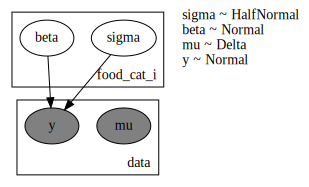

In [105]:
# should be: beta -> mu -> y
pyro.render_model(
    unpooled_model, (food_category, customers, sales),
    render_distributions=True
)

In [106]:
kernel = NUTS(unpooled_model)
mcmc_unpooled = MCMC(kernel, 500, 300)
mcmc_unpooled.run(food_category, customers, sales)

Sample: 100%|██████████| 800/800 [00:04, 171.15it/s, step size=5.88e-01, acc. prob=0.889]


In [107]:
mcmc_unpooled.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     13.02      0.03     13.02     12.97     13.07    678.99      1.00
   beta[1]      8.13      0.20      8.13      7.82      8.45    395.54      1.00
   beta[2]      6.11      0.05      6.11      6.03      6.19    574.60      1.00
  sigma[0]     40.09      1.39     39.99     37.95     42.38    778.36      1.00
  sigma[1]     21.57      8.38     19.84     11.07     35.72    507.41      1.01
  sigma[2]     36.13      2.58     36.10     32.26     40.33    560.15      1.00

Number of divergences: 0


In [ ]:
unpooled_posterior_samples = mcmc_unpooled.get_samples(1000)
unpooled_predictive = \
    Predictive(unpooled_model, unpooled_posterior_samples)(food_category, customers, None)

az_unpooled_inf = az.from_pyro(
    posterior=mcmc_unpooled, posterior_predictive=unpooled_predictive)

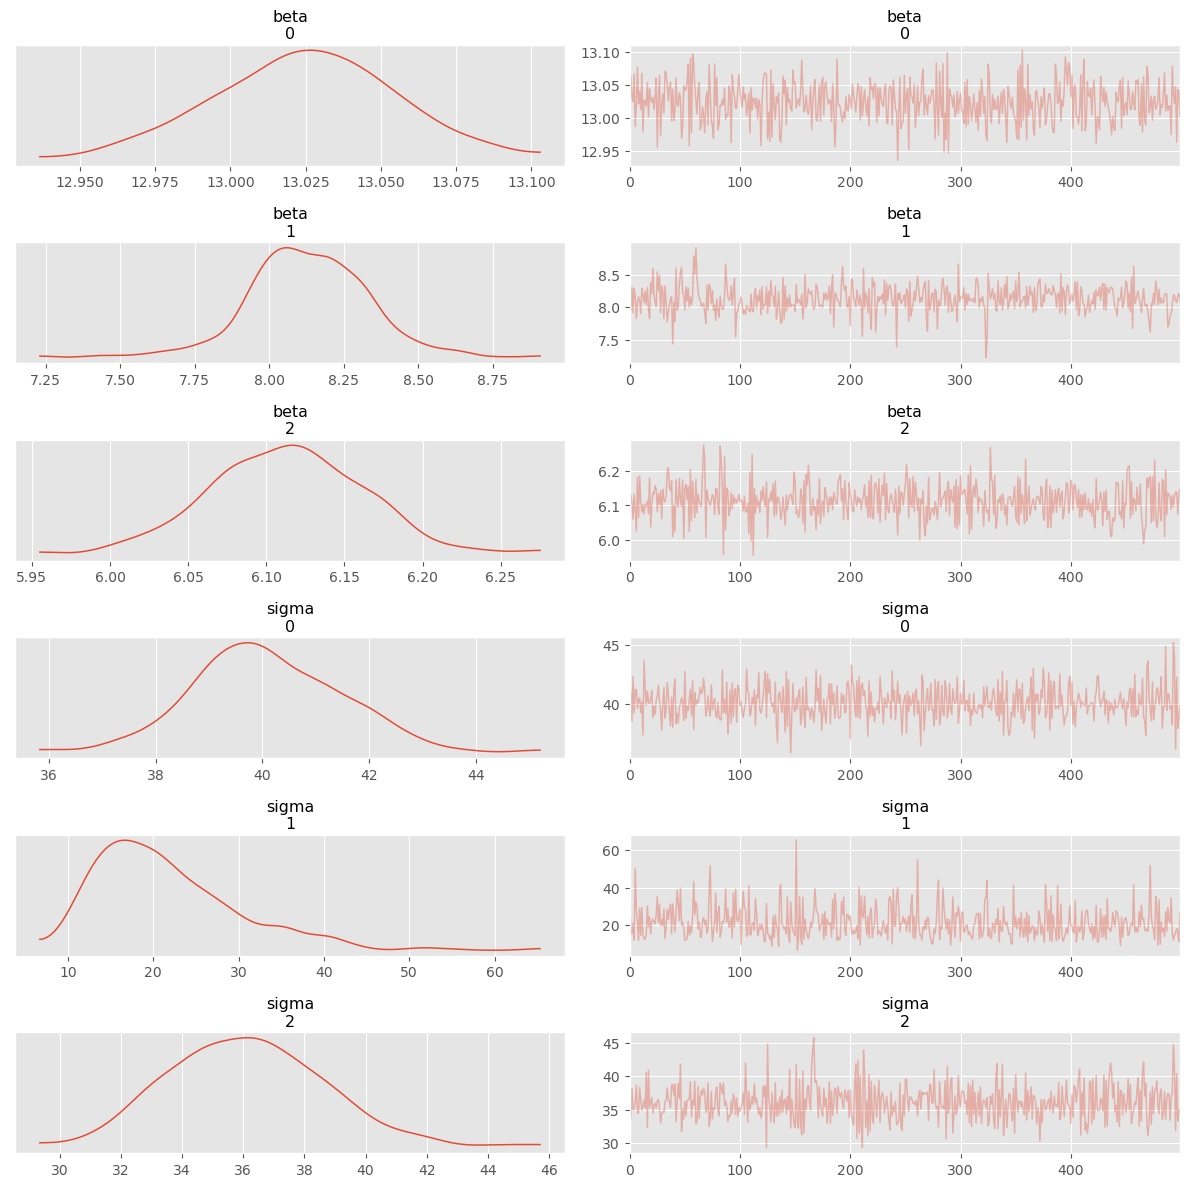

In [109]:
az.plot_trace(az_unpooled_inf, var_names=["beta", "sigma"], compact=False)
plt.tight_layout()

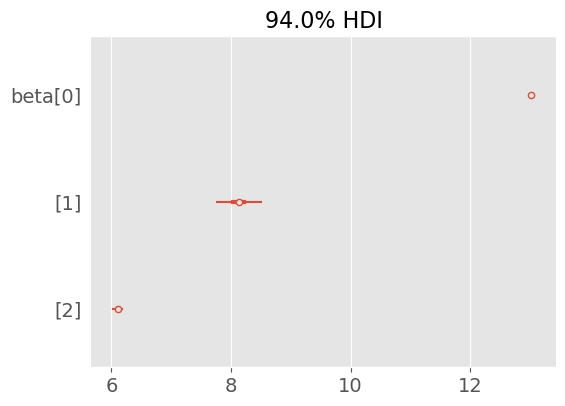

In [110]:
az.plot_forest(az_unpooled_inf, var_names=['beta'])
plt.show()

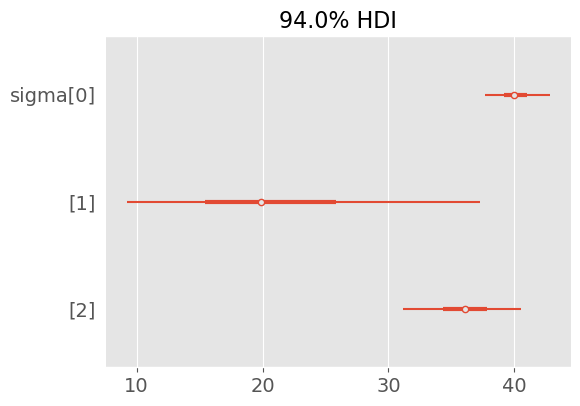

In [111]:
az.plot_forest(az_unpooled_inf, var_names=['sigma'])
plt.show()

### Unpooled - SVI

**NOT FINISHED**

In [307]:
def unpooled_model(food_cat, customers, sales=None):

    P = 3
    N = len(customers)

    with pyro.plate('food_cat_i', len(np.unique(food_cat))):
        sigma = pyro.sample('sigma', dist.HalfNormal(20.))
        beta = pyro.sample('beta', dist.Normal(10., 10.))
    
    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma[food_cat]), obs=sales)

In [11]:
def unpooled_guide(food_cat, customers, sales=None): 

    with pyro.plate('food_cat_i', len(np.unique(food_cat))):
        sigma_scale = pyro.param(
            'sigma_scale', torch.tensor(1.), constraint=constraints.positive
            )
        sigma = pyro.sample('sigma', dist.HalfNormal(sigma_scale))

        beta_loc = pyro.param('beta_loc', torch.tensor(10.))
        beta_scale = pyro.param(
            'beta_scale', torch.tensor(1.), constraint=constraints.positive)
        beta = pyro.sample('beta', dist.Normal(beta_loc, beta_scale))

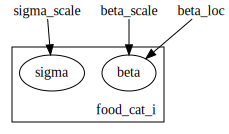

In [12]:
pyro.render_model(
    unpooled_guide, (food_category, customers, sales), render_params=True)

In [30]:
auto_guide = AutoLaplaceApproximation(unpooled_model)

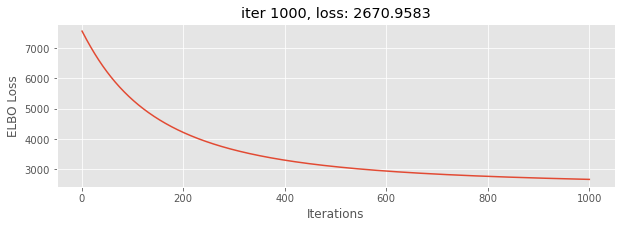

In [32]:
pyro.clear_param_store()

adam_params = {'lr': 0.002}
optim = Adam(adam_params)
svi = SVI(unpooled_model, auto_guide, optim, Trace_ELBO())

iter = 1000
elbo_loss = []
for i in range(iter):
    loss = svi.step(food_category, customers, sales)
    elbo_loss.append(loss)

plt.figure(figsize=(10, 3))
plt.plot(np.arange(1, iter+1), elbo_loss)
plt.ylabel('ELBO Loss')
plt.xlabel('Iterations')
plt.title(f'iter {len(elbo_loss)}, loss: {elbo_loss[-1]:.4f}')
plt.show()

In [33]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoLaplaceApproximation.loc [ 4.113231   3.4546025  3.8238153 12.153096   8.615855   6.703431 ]


In [34]:
predictive = Predictive(unpooled_model, guide=auto_guide, num_samples=1000)
posterior_svi_samples = predictive(food_category, customers, None)

### Pooled - MCMC

In [135]:
def pooled_model(customers, sales=None):

    P = 3
    N = len(customers)

    sigma = pyro.sample('sigma', dist.HalfNormal(20.))
    beta = pyro.sample('beta', dist.Normal(10., 10.))
    
    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma), obs=sales)

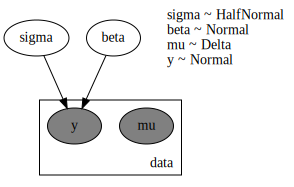

In [145]:
pyro.render_model(
    pooled_model, (customers, sales),
    render_distributions=True
)

In [136]:
kernel = NUTS(pooled_model)
mcmc_pooled = MCMC(kernel, 500, 300)
mcmc_pooled.run(customers, sales)

Sample: 100%|██████████| 800/800 [00:02, 289.74it/s, step size=7.09e-01, acc. prob=0.931]


In [137]:
mcmc_pooled.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta     11.50      0.12     11.50     11.32     11.70    530.37      1.00
     sigma    186.28      4.92    186.04    178.49    194.12    262.65      1.00

Number of divergences: 0


In [ ]:
pooled_samples = mcmc_pooled.get_samples(1000)
pooled_predictive = Predictive(pooled_model, pooled_samples)(customers, None)
az_pooled_inf = az.from_pyro(
    posterior=mcmc_pooled, posterior_predictive=pooled_predictive)

In [139]:
sales_mu = pooled_predictive['y'].mean(axis=0)
sales_std = pooled_predictive['y'].std(axis=0)

predictions = pd.DataFrame({
    'customers': customers,
    'category': food_category,
    'sales': sales, 
    'sales_mu': sales_mu,
    'sales_std': sales_std,
    'sales_high': sales_mu + sales_std,
    'sales_low': sales_mu - sales_std
})

predictions = predictions.sort_values(by=['customers'])

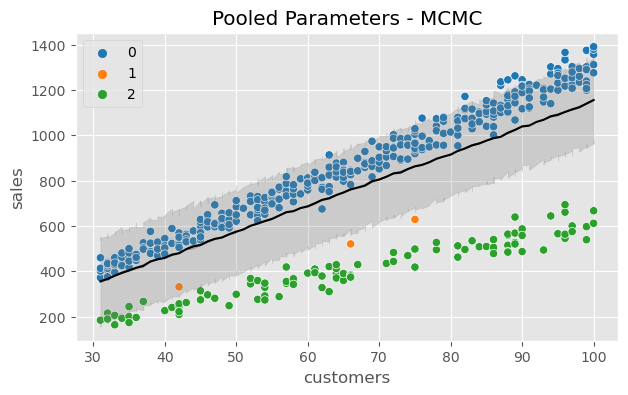

In [140]:
sns.scatterplot(
    x=predictions['customers'], y=predictions['sales'], 
    hue=predictions['category'], palette='tab10')
sns.lineplot(
    x=predictions['customers'], y=predictions['sales_mu'],
    color='black')
plt.fill_between(
    x=predictions['customers'], 
    y1=predictions['sales_low'], 
    y2=predictions['sales_high'],
    color='grey',
    alpha=0.25)
plt.title('Pooled Parameters - MCMC')
plt.show()

### Pooled - SVI

Using LaPlace Approximation doesn't make the most sense since. . .

`pooled_guide` learns `beta`, but does not learn `sigma`. This could be related to parameter initialization

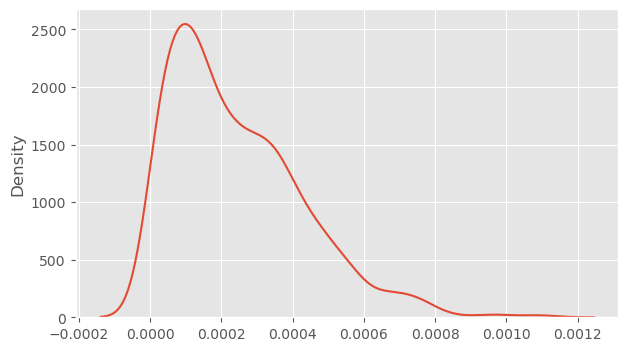

In [121]:
sigma = dist.TransformedDistribution(
        dist.Normal(torch.tensor(0.), 0.1 * torch.rand(1)), transforms=transforms.AbsTransform()
    )

sns.kdeplot(x=sigma.sample((1000,)).reshape(1, -1)[0]);

In [7]:
def pooled_model(customers, sales=None):

    P = 3
    N = len(customers)

    sigma = pyro.sample('sigma', dist.HalfNormal(20.))
    beta = pyro.sample('beta', dist.Normal(10., 10.))
    
    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma), obs=sales)

In [175]:
def pooled_guide(customers, sales=None): 

    sigma_scale = pyro.param(
        'sigma_scale', 0.1 * torch.rand(1), constraint=constraints.positive
        )

    sigma_loc = pyro.param(
        'sigma_loc', torch.tensor(0.))
    
    sigma = pyro.sample('sigma', dist.TransformedDistribution(
        dist.Normal(sigma_loc, sigma_scale), transforms=transforms.AbsTransform()
    ))

    beta_loc = pyro.param('beta_loc', torch.tensor(1.))
    beta_scale = pyro.param(
        'beta_scale', 0.1 * torch.rand(1), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_loc, beta_scale))

In [ ]:
pyro.render_model(
    pooled_guide (customers, sales), render_params=True)

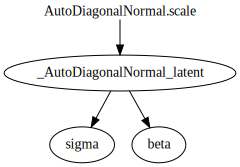

In [8]:
auto_guide = pyro.infer.autoguide.AutoDiagonalNormal(pooled_model)
pyro.render_model(auto_guide, (customers, sales, ), render_params=True)

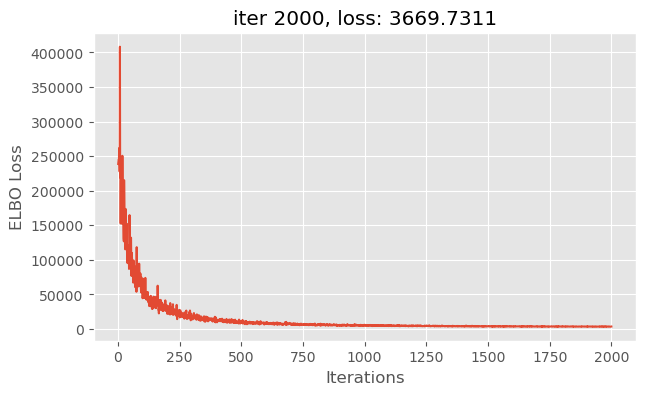

In [9]:
pyro.clear_param_store()

#adam_params = {'lr': 0.005, 'betas': (0.95, 0.99)}
adam_params = {'lr': 0.01}
optim = Adam(adam_params)
svi = SVI(pooled_model, auto_guide, optim, Trace_ELBO())

iter = 2000
elbo_loss = []
for i in range(iter):
    loss = svi.step(customers, sales)
    #loss = svi.step(food_category, customers, sales)
    elbo_loss.append(loss)

plt.plot(np.arange(1, iter+1), elbo_loss)
plt.ylabel('ELBO Loss')
plt.xlabel('Iterations')
plt.title(f'iter {len(elbo_loss)}, loss: {elbo_loss[-1]:.4f}')
plt.show()

In [11]:
predictive = Predictive(pooled_model, guide=auto_guide, num_samples=1000)
posterior_svi_samples = predictive(customers, None)

In [12]:
sales_mu = posterior_svi_samples['y'].mean(axis=0)
sales_std = posterior_svi_samples['y'].std(axis=0)

predictions_svi = pd.DataFrame({
    'customers': customers,
    'category': food_category,
    'sales': sales, 
    'sales_mu': sales_mu,
    'sales_std': sales_std,
    'sales_high': sales_mu + sales_std,
    'sales_low': sales_mu - sales_std
})

predictions_svi = predictions_svi.sort_values(by=['customers'])

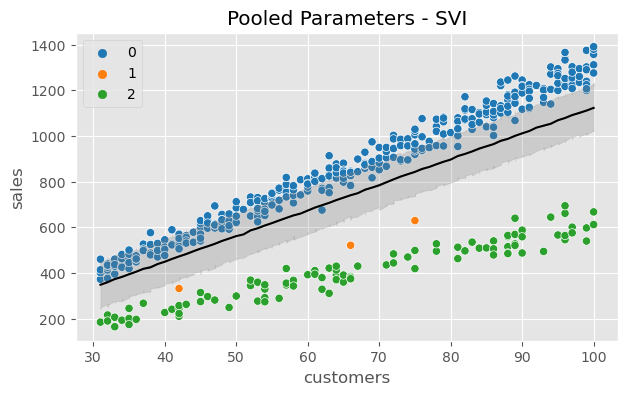

In [13]:
sns.scatterplot(
    x=predictions_svi['customers'], y=predictions_svi['sales'], 
    hue=predictions_svi['category'], palette='tab10')
sns.lineplot(
    x=predictions_svi['customers'], y=predictions_svi['sales_mu'],
    color='black')
plt.fill_between(
    x=predictions_svi['customers'], 
    y1=predictions_svi['sales_low'], 
    y2=predictions_svi['sales_high'],
    color='grey',
    alpha=0.25)
plt.title('Pooled Parameters - SVI')
plt.show()

### Mixing Group and Common Parameters - MCMC

In [14]:
customers_z = (customers - customers.mean()) / (customers.std())
sales_std = sales / sales.max()

In [15]:
def pooled_sigma_model(food_cat, customers, sales=None):

    P = len(np.unique(food_cat))
    N = len(customers)

    with pyro.plate('food_cat_i', P):
        beta = pyro.sample('beta', dist.Normal(10., 20.))
    
    sigma = pyro.sample('sigma', dist.HalfNormal(20.))

    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma), obs=sales)

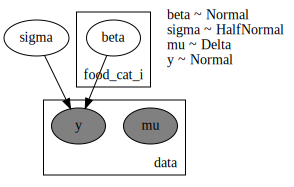

In [16]:
pyro.render_model(
    pooled_sigma_model, (food_category, customers, sales),
    render_distributions=True
)

In [17]:
kernel = NUTS(pooled_sigma_model)
mcmc_pooled_sigma = MCMC(kernel, 500, 300)
mcmc_pooled_sigma.run(food_category, customers, sales)

Sample: 100%|██████████| 800/800 [00:03, 210.80it/s, step size=7.51e-01, acc. prob=0.906]


In [18]:
mcmc_pooled_sigma.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     13.02      0.03     13.02     12.97     13.06    673.42      1.00
   beta[1]      8.15      0.33      8.14      7.62      8.72    579.90      1.00
   beta[2]      6.11      0.06      6.11      6.02      6.21    396.32      1.00
     sigma     39.19      1.24     39.21     36.88     40.96    545.10      1.00

Number of divergences: 0


In [ ]:
pooled_sigma_samples = mcmc_pooled_sigma.get_samples(1000)
pooled_sigma_predictive = Predictive(pooled_sigma_model, pooled_sigma_samples)(food_category, customers, None)
az_pooled_sigma_inf = az.from_pyro(
    posterior=mcmc_pooled_sigma, posterior_predictive=pooled_sigma_predictive)

/Users/gabestechschulte/miniforge3/envs/probs/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/gabestechschulte/miniforge3/envs/probs/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/gabestechschulte/miniforge3/envs/probs/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob

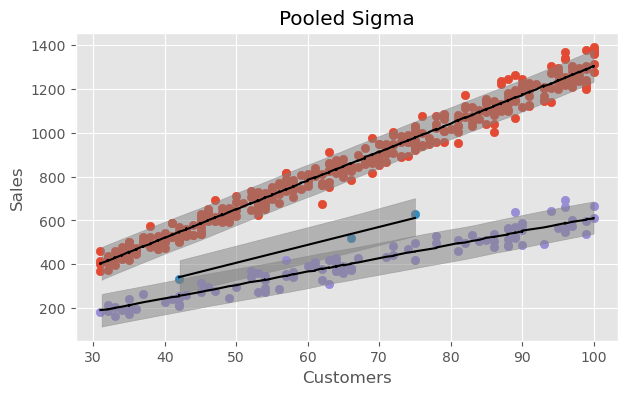

In [21]:
sales_df['food_cat_encode'] = food_category
sales_df['sales_std'] = sales_std
sales_df['customers_z'] = customers_z

fig, ax = plt.subplots()

for i in range(3):
    category_mask = sales_df['food_cat_encode'] == i
    mu_cat = pooled_sigma_predictive['y'][:, category_mask].mean(axis=0)

    customers = sales_df.loc[category_mask, ['customers']].values.flatten()
    sales = sales_df.loc[category_mask, ['sales']].values.flatten()

    ax.plot(customers, mu_cat, c='black')
    ax.scatter(customers, sales)
    az.plot_hdi(
        x=customers,
        y=pooled_sigma_predictive['y'][:, category_mask],
        color='grey'
    )
    
ax.set_xlabel('Customers')
ax.set_ylabel('Sales')
ax.set_title('Pooled Sigma');

### Mixing Group and Common Parameters - SVI

Using LaPlace approximation

In [22]:
customers_z = (customers - customers.mean()) / (customers.std())
sales_std = sales / sales.max()

In [23]:
def pooled_sigma_model(food_cat, customers, sales=None):

    P = len(np.unique(food_cat))
    N = len(customers)

    with pyro.plate('food_cat_i', P):
        beta = pyro.sample('beta', dist.Normal(10., 20.))
    
    sigma = pyro.sample('sigma', dist.HalfNormal(20.))

    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma), obs=sales)

In [356]:
from torch.distributions import constraints, transforms

def pool_sigma_guide(food_cat, customers, sales=None):

    P = len(np.unique(food_cat))
    N = len(customers)

    with pyro.plate('food_cat_i', P):
        
        beta_scale = pyro.param(
            'beta_scale', torch.tensor(1.), constraint=constraints.positive)
        beta_loc = pyro.param('beta_loc', torch.randn(1))
        beta = pyro.sample('beta', dist.Normal(beta_loc, beta_scale))
    
    sigma_loc = pyro.param(
        'sigma_loc', torch.randn(1))
    
    sigma_scale = pyro.param(
        'sigma_scale', 0.1 * torch.rand(1), constraint=constraints.positive)
    
    sigma = pyro.sample('sigma', dist.TransformedDistribution(
        dist.Normal(sigma_loc, sigma_scale), transforms=transforms.ExpTransform()
    ))
    #sigma = pyro.sample('sigma', dist.HalfCauchy(sigma_scale))

In [ ]:
pyro.render_model(
    pool_sigma_guide, (food_category, customers, sales), render_params=True)

In [358]:
auto_guide = AutoLaplaceApproximation(pooled_sigma_model)

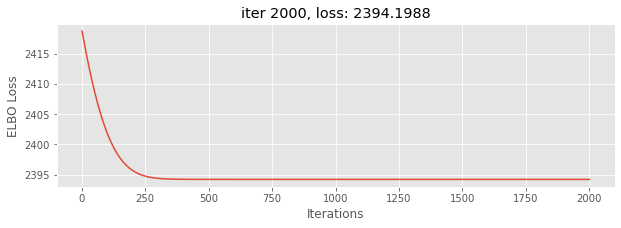

In [377]:
customers = torch.tensor(sales_df['customers'].values, dtype=torch.float64)
sales = torch.tensor(sales_df['sales'].values, dtype=torch.float64)
food_category = torch.tensor(sales_df['Food_Category'].cat.codes.values, dtype=torch.long)

pyro.clear_param_store()

adam_params = {'lr': 0.002}
optim = Adam(adam_params)
svi = SVI(pooled_sigma_model, auto_guide, optim, Trace_ELBO())
#svi = SVI(pooled_sigma_model, pool_sigma_guide, optim, Trace_ELBO())

iter = 2000
elbo_loss = []
for i in range(iter):
    loss = svi.step(food_category, customers, sales)
    elbo_loss.append(loss)

plt.plot(np.arange(1, iter+1), elbo_loss)
plt.ylabel('ELBO Loss')
plt.xlabel('Iterations')
plt.title(f'iter {len(elbo_loss)}, loss: {elbo_loss[-1]:.4f}')
plt.show()

In [378]:
predictive = Predictive(pooled_sigma_model, guide=auto_guide, num_samples=1000)
posterior_svi_samples = predictive(food_category, customers, None)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circula

Text(0.5, 1.0, 'Pooled Sigma')

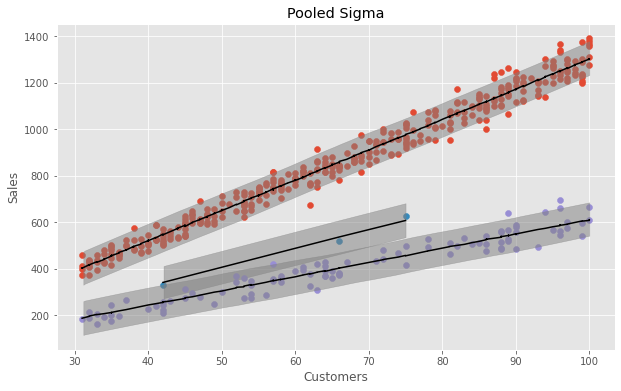

In [379]:
sales_df['food_cat_encode'] = food_category

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(3):
    category_mask = sales_df['food_cat_encode'] == i
    mu_cat = posterior_svi_samples['y'][:, category_mask].mean(axis=0)

    customers = sales_df.loc[category_mask, ['customers']].values.flatten()
    sales = sales_df.loc[category_mask, ['sales']].values.flatten()

    ax.plot(customers, mu_cat, c='black')
    ax.scatter(customers, sales)
    az.plot_hdi(
        x=customers,
        y=posterior_svi_samples['y'][:, category_mask],
        color='grey'
    )
    
ax.set_xlabel('Customers')
ax.set_ylabel('Sales')
ax.set_title('Pooled Sigma')

## Hierarchical Models

In the multi-level model above, the $\sigma$ is assumed to be the same for all 3 categories. Instead, we can say that $\sigma$ comes from the same underlying distribution, **but** is allowed to vary by category.

In [24]:
def unpooled_model(food_cat, customers, sales=None):

    P = 3
    N = len(customers)

    with pyro.plate('food_cat_i', len(np.unique(food_cat))):
        sigma = pyro.sample('sigma', dist.HalfNormal(20.))
        beta = pyro.sample('beta', dist.Normal(10., 10.))
    
    with pyro.plate('data', N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma[food_cat]), obs=sales)

In [7]:
def hierarchical_model(food_cat, customers, sales=None):

    N = len(customers)
    P = len(np.unique(food_cat))

    sigma_hyperprior = pyro.sample('sigma_hyperprior', dist.HalfNormal(20.))

    with pyro.plate('food_cat_i', size=P):
        beta = pyro.sample('beta', dist.Normal(10., 20.))
        sigma = pyro.sample('sigma', dist.HalfNormal(sigma_hyperprior))
    
    with pyro.plate('output', size=N):
        mu = pyro.deterministic('mu', beta[food_cat] * customers)
        output = pyro.sample('y', dist.Normal(mu, sigma[food_cat]), obs=sales)

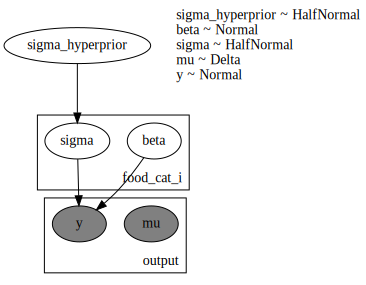

In [8]:
pyro.render_model(
    hierarchical_model, (food_category, customers, sales),
    render_distributions=True
)

In [9]:
kernel = NUTS(hierarchical_model)
mcmc_hm = MCMC(kernel, 500, 300)
mcmc_hm.run(food_category, customers, sales)

Sample: 100%|██████████| 800/800 [00:07, 112.51it/s, step size=4.78e-01, acc. prob=0.868]


In [10]:
mcmc_hm.summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
           beta[0]     13.02      0.03     13.02     12.97     13.07    392.00      1.00
           beta[1]      8.13      0.28      8.13      7.76      8.59    419.29      1.00
           beta[2]      6.12      0.05      6.11      6.04      6.20    581.77      1.00
          sigma[0]     40.28      1.44     40.20     38.08     42.58    347.26      1.00
          sigma[1]     26.57     12.56     23.87      8.74     44.99    323.47      1.00
          sigma[2]     36.24      2.63     36.11     32.35     40.71    503.11      1.00
  sigma_hyperprior     31.52      9.10     30.20     16.75     45.43    542.93      1.00

Number of divergences: 2


### Posterior Geometry Matters

In [11]:
def salad_generator(hyperprior_beta_mean=5, hyperprior_beta_sigma=.2, 
sigma=50, days_per_location=[6, 4, 15, 10, 3, 5], 
sigma_per_location=[50,10,20,80,30,20]):
    """Generate noisy salad data"""

    beta_hyperprior = stats.norm(hyperprior_beta_mean, hyperprior_beta_sigma)
    
    # Generate demands days per restaurant
    df = pd.DataFrame()
    for i, days in enumerate(days_per_location):
        np.random.seed(0)

        num_customers = stats.randint(30, 100).rvs(days)
        sales_location = beta_hyperprior.rvs()*num_customers + stats.norm(0, sigma_per_location[i]).rvs(num_customers.shape)

        location_df = pd.DataFrame({"customers":num_customers, "sales":sales_location})
        location_df["location"] = i
        location_df.sort_values(by="customers", ascending=True)
        df = pd.concat([df, location_df])
        
    df.reset_index(inplace=True, drop=True)
    
    return df

hierarchical_salad_df = salad_generator()

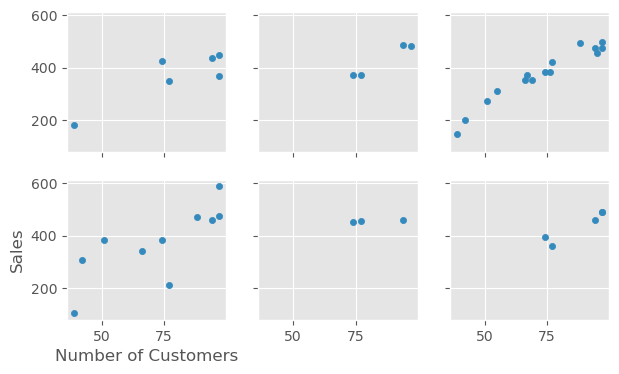

In [12]:
fig, axes, = plt.subplots(2,3, sharex=True, sharey=True)

for i, ax in enumerate(axes.ravel()):
    location_filter = (hierarchical_salad_df["location"] == i)
    hierarchical_salad_df[location_filter].plot(
        kind="scatter", x="customers", y="sales", ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")

axes[1, 0].set_xlabel("Number of Customers")
axes[1, 0].set_ylabel("Sales");

In [13]:
customers = torch.tensor(
    hierarchical_salad_df['customers'].values, dtype=torch.float)
sales = torch.tensor(
    hierarchical_salad_df['sales'].values, dtype=torch.float)
location = torch.tensor(
    hierarchical_salad_df['location'].values, dtype=torch.long)

In [14]:
def hierarchical_salad_model(customers, location, sales=None):

    N = len(customers)
    P = len(np.unique(location))

    beta_loc_hyper = pyro.sample('beta_loc_hyper', dist.Normal(0., 10.))
    beta_scale_hyper = pyro.sample('beta_scale_hyper', dist.HalfNormal(.1))
    sigma_hyper = pyro.sample('sigma_hyper', dist.HalfNormal(30.))

    with pyro.plate('location_i', size=P):
        beta = pyro.sample('beta', dist.Normal(beta_loc_hyper, beta_scale_hyper))
        sigma = pyro.sample('sigma', dist.HalfNormal(sigma_hyper))
    
    with pyro.plate('output', size=N):
        mu = pyro.deterministic('mu', beta[location] * sigma[location])
        output = pyro.sample('y', dist.Normal(mu, sigma[location]), obs=sales)


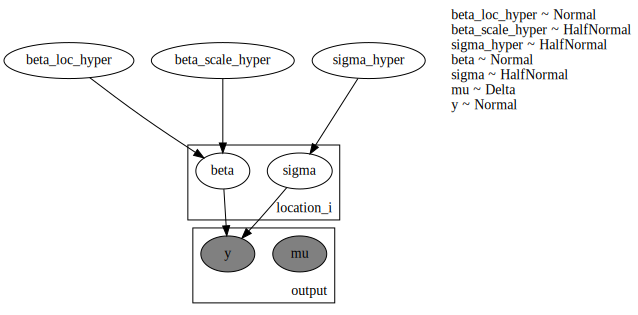

In [15]:
pyro.render_model(
    hierarchical_salad_model, (customers, location, sales),
    render_distributions=True
)

In [16]:
kernel = NUTS(hierarchical_salad_model)
mcmc_salad = MCMC(kernel, 500, 300)
mcmc_salad.run(customers, location, sales)

Sample: 100%|██████████| 800/800 [00:51, 15.55it/s, step size=8.40e-02, acc. prob=0.714] 


In [17]:
mcmc_salad.summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
           beta[0]      3.97      0.44      4.04      3.27      4.66      8.21      1.37
           beta[1]      3.97      0.43      4.06      3.29      4.66      8.02      1.38
           beta[2]      3.95      0.43      4.02      3.34      4.73      7.88      1.38
           beta[3]      3.94      0.43      4.02      3.29      4.67      7.87      1.38
           beta[4]      3.97      0.43      4.05      3.35      4.75      7.70      1.38
           beta[5]      3.97      0.44      4.04      3.35      4.72      7.98      1.39
    beta_loc_hyper      3.96      0.43      4.04      3.31      4.64      7.56      1.40
  beta_scale_hyper      0.08      0.06      0.07      0.02      0.16     16.84      1.07
          sigma[0]     95.53     13.35     94.09     71.52    112.00     31.79      1.11
          sigma[1]    110.74     16.58    112.76     82.07    129.72     37.98      1.01
          sigma[2]  

In [ ]:
salad_samples = mcmc_salad.get_samples(1000)
salad_predictive_samples = Predictive(
    hierarchical_salad_model, salad_samples)(customers, location, None)

az_salad_inf = az.from_pyro(
    posterior=mcmc_salad, posterior_predictive=salad_predictive_samples)

In [19]:
slope_centered = salad_samples['beta'][..., 4].numpy().flatten()
sigma_centered = salad_samples['beta_scale_hyper'].numpy().flatten()
divergences_centered = np.array(mcmc_salad.diagnostics()['divergences']['chain 0'])

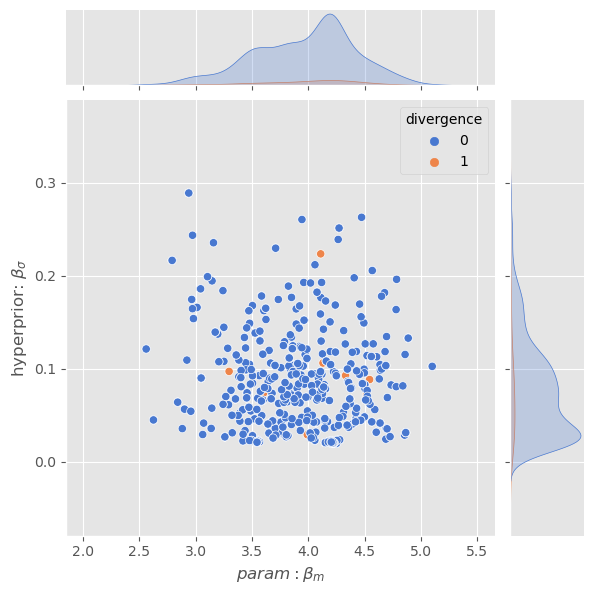

In [20]:
divergent_samples = pd.DataFrame({
    'slope': slope_centered,
    'sigma': sigma_centered
})

mask = divergent_samples.index.isin(pd.Index(divergences_centered))
divergent_samples['divergence'] = [1 if booly == True else 0 for booly in mask]

ax = sns.jointplot(
    data=divergent_samples, x='slope', y='sigma', 
    color='grey', hue='divergence', palette="muted")
ax.set_axis_labels(xlabel='$param: \\beta_m}$', ylabel='hyperprior: $\\beta_{\sigma}$');

In [21]:
def non_centered_hierarchical_salad_model(customers, location, sales=None):

    N = len(customers)
    P = len(np.unique(location))

    beta_loc_hyper = pyro.sample('beta_loc_hyper', dist.Normal(0., 10.))
    beta_scale_hyper = pyro.sample('beta_scale_hyper', dist.HalfNormal(.1))
    sigma_hyper = pyro.sample('sigma_hyper', dist.HalfNormal(30.))

    with pyro.plate('location_i', size=P):
        beta_offset = pyro.sample('beta_offset', dist.Normal(0., 1.))
        #beta = pyro.sample('beta', dist.Normal(beta_loc_hyper, beta_scale_hyper))
        sigma = pyro.sample('sigma', dist.HalfNormal(sigma_hyper))
        beta = pyro.deterministic('beta', beta_offset * beta_scale_hyper + beta_loc_hyper) 
    
    with pyro.plate('output', size=N):
        mu = pyro.deterministic('mu', beta[location] * sigma[location])
        output = pyro.sample('y', dist.Normal(mu, sigma[location]), obs=sales)

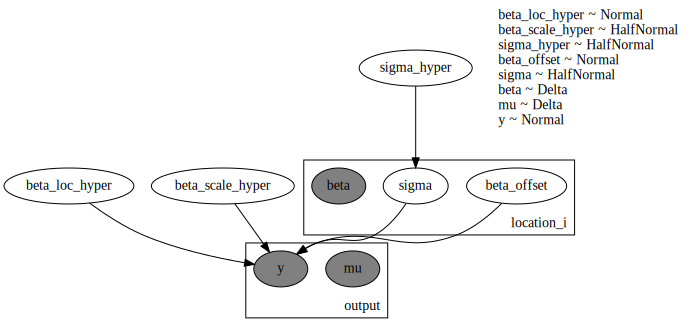

In [22]:
pyro.render_model(
    non_centered_hierarchical_salad_model, 
    (customers, location, sales),
    render_distributions=True
)

In [23]:
kernel = NUTS(non_centered_hierarchical_salad_model)
mcmc_non_centered_salad = MCMC(kernel, 500, 300)
mcmc_non_centered_salad.run(customers, location, sales)

Sample: 100%|██████████| 800/800 [00:21, 37.13it/s, step size=3.39e-01, acc. prob=0.892]


In [24]:
mcmc_non_centered_salad.summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_loc_hyper      3.96      0.44      3.94      3.16      4.56    191.41      1.01
    beta_offset[0]     -0.01      1.05      0.03     -1.73      1.88    655.40      1.00
    beta_offset[1]      0.10      1.05      0.11     -1.50      1.79    433.58      1.00
    beta_offset[2]     -0.01      0.96     -0.03     -1.53      1.56    710.84      1.00
    beta_offset[3]     -0.06      1.06     -0.04     -1.61      1.74    758.38      1.00
    beta_offset[4]      0.11      0.97      0.12     -1.34      1.88    590.92      1.00
    beta_offset[5]      0.16      0.89      0.11     -1.24      1.64    503.59      1.00
  beta_scale_hyper      0.08      0.06      0.07      0.00      0.16    422.26      1.00
          sigma[0]     94.50     13.61     92.37     74.43    116.52    293.44      1.00
          sigma[1]    105.06     17.08    102.42     76.38    131.42    306.25      1.00
          sigma[2]  

In [ ]:
non_centered_salad_samples = mcmc_non_centered_salad.get_samples(1000)
salad_predictive_samples = Predictive(
    non_centered_hierarchical_salad_model, non_centered_salad_samples)(customers, location, None)

az_salad_inf = az.from_pyro(
    posterior=mcmc_non_centered_salad, posterior_predictive=salad_predictive_samples)

In [26]:
slope_un_centered = salad_predictive_samples['beta'][..., 4].numpy().flatten() ## index 4th beta param
sigma_un_centered = non_centered_salad_samples['beta_scale_hyper'].numpy().flatten()
divergences_un_centered = np.array(mcmc_non_centered_salad.diagnostics()['divergences']['chain 0'])

In [27]:
non_centered = pd.DataFrame({
    'beta_b4': slope_un_centered,
    'beta_sigma_hyper': sigma_un_centered,
    'parameterization': 'non_centered'
})

non_centered_mask = non_centered.index.isin(pd.Index(divergences_un_centered))
non_centered['divergence'] = [1 if booly == True else 0 for booly in non_centered_mask]

centered = pd.DataFrame({
    'beta_b4': slope_centered,
    'beta_sigma_hyper': sigma_centered,
    'parameterization': 'centered'
})

centered_mask = centered.index.isin(pd.Index(divergences_centered))
centered['divergence'] = [1 if booly == True else 0 for booly in centered_mask]

df = pd.concat([non_centered, centered])

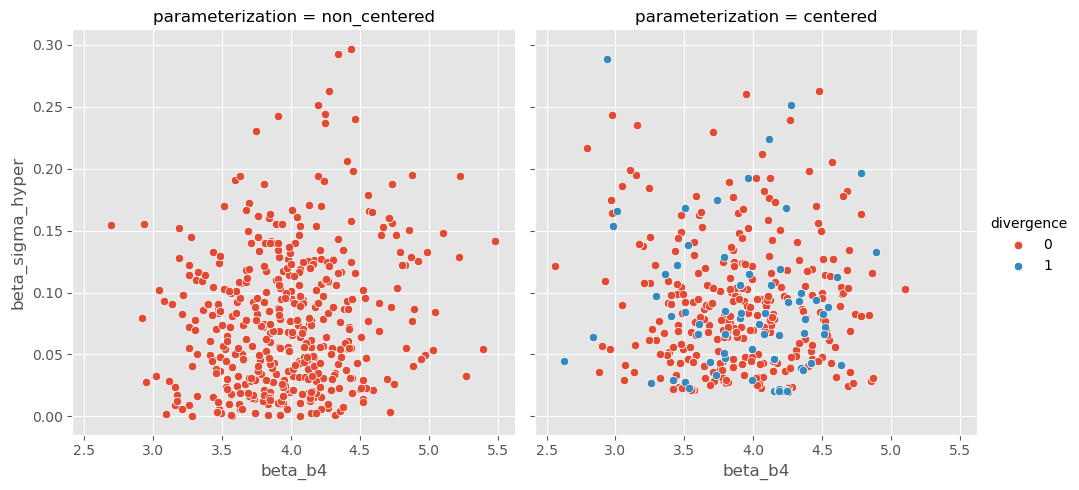

In [28]:
g = sns.FacetGrid(df, col='parameterization', hue='divergence', height=5)
g.map_dataframe(sns.scatterplot, 'beta_b4', 'beta_sigma_hyper')
g.set_axis_labels(xlabel='$\\beta_[4]$', ylabel='$\\beta_{\sigma h}$')
g.add_legend()
plt.show()

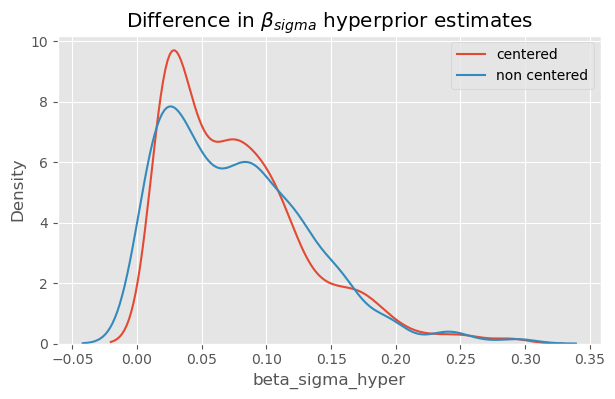

In [35]:
sns.kdeplot(df[df['parameterization'] == 'centered']['beta_sigma_hyper'])
sns.kdeplot(df[df['parameterization'] == 'non_centered']['beta_sigma_hyper'])
plt.legend(['centered', 'non centered'])
plt.title('Difference in $\\beta_{sigma}$ hyperprior estimates');

### Predictions at Multiple Levels

Using the fitted parameter estimates to make an out of sample prediction for the distribution of sales for 50 customers.
- posterior predictive: learned parameters; the data the model expects to see
- customer = data $x$

In [31]:
# .reshape(-1, 1) to ensure dimensions remain as [1000, 6] when multiplying
# 6 b/c of 6 locations
beta = (
    non_centered_salad_samples['beta_offset'] * 
    non_centered_salad_samples['beta_scale_hyper'].reshape(-1, 1) + 
    non_centered_salad_samples['beta_loc_hyper'].reshape(-1, 1)
    )

beta.size()

torch.Size([1000, 6])

In [32]:
beta_group = dist.Normal(
    non_centered_salad_samples['beta_loc_hyper'],
    non_centered_salad_samples['beta_scale_hyper']
    ).sample((100,))

# aggregate predictions
group_level_sales_prediction = dist.Normal(
    beta_group * 50, 
    non_centered_salad_samples['sigma_hyper']
    ).sample((100,))

# location 2 and 4
location_two = dist.Normal(
    beta[:, 2] * 50,
    non_centered_salad_samples['sigma'][:, 2]
    ).sample((100,))

location_four = dist.Normal(
    beta[:, 4] * 50,
    non_centered_salad_samples['sigma'][:, 4]
    ).sample((100,))

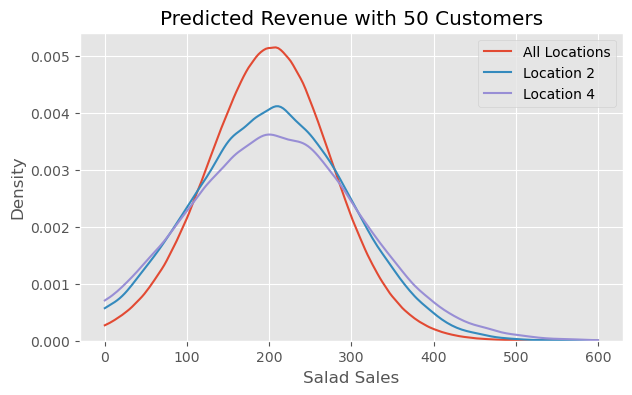

In [36]:
sns.kdeplot(group_level_sales_prediction.flatten(), clip=[0, 600])
sns.kdeplot(location_two.flatten(), clip=[0, 600])
sns.kdeplot(location_four.flatten(), clip=[0, 600])
plt.legend(['All Locations', 'Location 2', 'Location 4'])
plt.xlabel('Salad Sales')
plt.title('Predicted Revenue with 50 Customers');